In [0]:
!pip install tensorflow==2.0.0b1

     |████████████████████████████████| 87.9MB 33kB/s 
     |████████████████████████████████| 501kB 61.0MB/s 
     |████████████████████████████████| 3.1MB 34.6MB/s 
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [0]:
import tensorflow as tf
print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

2.0.0-beta1


/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-01-08 02:07:10--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.009s  

2020-01-08 02:07:10 (7.41 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



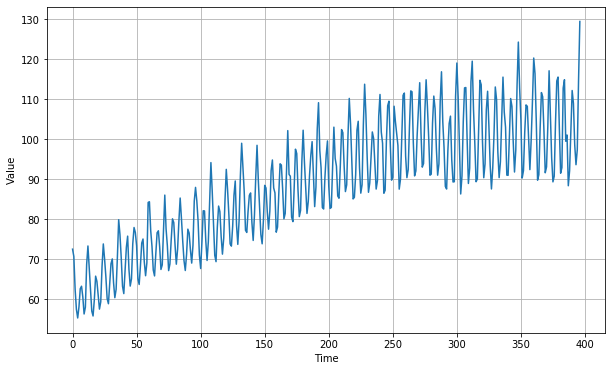

In [0]:
import csv
time_step = []
temps = []

with open('/tmp/Electric_Production.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 280
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = split_time



In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
tf.keras.backend.clear_session()
# tf.random.set_seed(0)
# np.random.seed(0)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(280,)
Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 67.6550 - mae: 68.1549
Epoch 2/100
1/1 [==============================] - 0s 306ms/step - loss: 67.2112 - mae: 67.7111
Epoch 3/100
1/1 [==============================] - 0s 311ms/step - loss: 66.3174 - mae: 66.8172
Epoch 4/100
1/1 [==============================] - 0s 329ms/step - loss: 64.9662 - mae: 65.4660
Epoch 5/100
1/1 [==============================] - 0s 303ms/step - loss: 63.1524 - mae: 63.6522
Epoch 6/100
1/1 [==============================] - 0s 301ms/step - loss: 60.8738 - mae: 61.3736
Epoch 7/100
1/1 [==============================] - 0s 319ms/step - loss: 58.1404 - mae: 58.6400
Epoch 8/100
1/1 [==============================] - 0s 308ms/step - loss: 54.9809 - mae: 55.4804
Epoch 9/100
1/1 [==============================] - 0s 333ms/step - loss: 51.4579 - mae: 51.9573
Epoch 10/100
1/1 [====================

[1e-08, 0.0001, 0, 60]

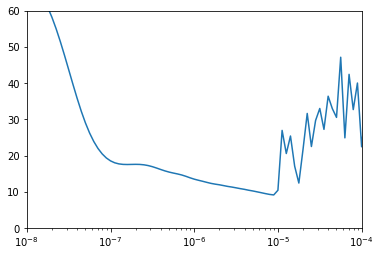

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [0]:
tf.keras.backend.clear_session()
# tf.random.set_seed(51)
# np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
3/3 [==============================] - 3s 990ms/step - loss: 36.9540 - mae: 45.9197
Epoch 2/150
3/3 [==============================] - 0s 97ms/step - loss: 17.8892 - mae: 18.8467
Epoch 3/150
3/3 [==============================] - 0s 106ms/step - loss: 14.1165 - mae: 14.5374
Epoch 4/150
3/3 [==============================] - 0s 96ms/step - loss: 12.2646 - mae: 12.2977
Epoch 5/150
3/3 [==============================] - 0s 94ms/step - loss: 10.9881 - mae: 11.5462
Epoch 6/150
3/3 [==============================] - 0s 96ms/step - loss: 10.7487 - mae: 11.3877
Epoch 7/150
3/3 [==============================] - 0s 104ms/step - loss: 9.9847 - mae: 10.6223
Epoch 8/150
3/3 [==============================] - 0s 102ms/step - loss: 9.7209 - mae: 10.3750
Epoch 9/150
3/3 [==============================] - 0s 91ms/step - loss: 9.1156 - mae: 9.5704
Epoch 10/150
3/3 [==============================] - 0s 100ms/step - loss: 8.6718 - mae: 9.1722
Epoch 11/150
3/3 [==============================] 

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

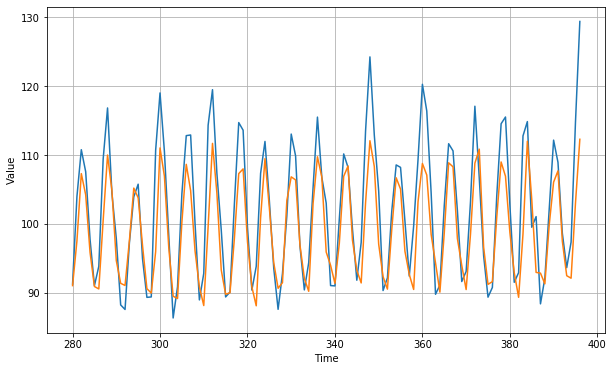

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

4.127591

In [0]:
print(rnn_forecast)

[ 91.00318   97.507835 107.2854   104.21407   95.82306   90.87509
  90.5226   100.50767  109.98753  104.831375  94.63781   91.33793
  91.02646   97.5577   105.17943  103.77256   96.82971   90.561066
  89.92929   95.94525  111.01937  106.930565  96.51131   89.46109
  89.12593  100.22361  108.63393  104.814705  96.096466  90.84133
  88.10804   99.570694 111.6795   104.49244   93.27495   89.74639
  89.96557   97.8255   107.287834 107.97094   97.36885   90.81757
  88.0717   100.87609  109.457794 102.31107   94.34903   90.617035
  91.431915 103.39137  106.81481  106.374504  96.906364  92.065094
  90.17967  102.94162  109.73358  106.7791    95.88485   93.95663
  91.32101   97.157455 106.897995 108.39483   97.637535  93.23167
  91.39302  103.040436 112.06913  108.3206    97.03481   92.3158
  90.49473   99.23382  106.680145 105.03945   96.01706   92.62128
  90.44583  103.18029  108.758965 107.07668   98.44079   94.293785
  90.05737   98.66943  108.85817  108.271454  97.8519    93.93427
  90.43